## Site mean paleomagnetic direction, stereoplots and unfolding.

**Calculates mean paleomagnetic directions and plots results in a stereonet in geographic and stratigraphic coordinates.**

**Applies multiple restoration steps for multiphase tectonic deformation (regional tilts, plunging fold axis,...)**

**Runs a test for Inclination error**

*Input data in an excel file with following headers:*

|header      |Description                                             | 
|:-----------|:-------------------------------------------------------|
|sample      |Sample code (name)                                      |
|Dg          |declination in geographic coordinates                   |
|Ig          |Inclination in geographic coordinates                   |
|So_dipdir   |Bedding dip direction                                   |
|So_dip      |Bedding dip                                             |
|Q           |Quality rank ChRM -->[1,2,3] Secondary components --> 4 |

The order and number of columns is not predetermined.

#### Importing modules and function definitions

In [1]:
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.ipmag as ipmag
import matplotlib.pyplot as plt # our plotting buddy
from pmagpy import convert_2_magic as convert
import numpy as np # the fabulous NumPy package
import pandas as pd # and of course Pandas
has_basemap, Basemap = pmag.import_basemap()
has_cartopy, Cartopy = pmag.import_cartopy()
from IPython.display import Image
%matplotlib inline 

In [2]:
#define a fisher_means function
def fisher_means(di_block,n, tc: bool, coord_sys = str, foldaxis_plunge = bool):
    mode_1,mode_2=pmag.separate_directions(di_block) #mode_1,mode_2: 2 arrays of nested dec,inc pairs
    # Calculates the Fisher mean and associated parameters
    mode_1_fpars=ipmag.fisher_mean(di_block=mode_1)
    mode_2_fpars=ipmag.fisher_mean(di_block=mode_2)
    mode_N_fpars = dict()
    mode_R_fpars = dict()

    # assign N and R polarity to mode 1 and mode 2
    if 'dec' in mode_1_fpars:
        if mode_1_fpars['dec'] >90 and mode_1_fpars['dec'] <270:
            mode_R_fpars = mode_1_fpars
            mode_R = mode_1
            mode_N_fpars = mode_2_fpars
            mode_N =mode_2
        else:
            mode_R_fpars = mode_2_fpars
            mode_R = mode_2
            mode_N_fpars = mode_1_fpars
            mode_N =mode_1
    else:
        if 'dec' in mode_2_fpars:
            if mode_2_fpars['dec'] >90 and mode_2_fpars['dec'] <270:
                mode_R_fpars = mode_2_fpars
                mode_R = mode_2
                mode_N_fpars = mode_1_fpars
                mode_N =mode_1
            else:
                mode_R_fpars = mode_1_fpars
                mode_R = mode_1
                mode_N_fpars = mode_2_fpars
                mode_N =mode_2
            
    
    # Build a dataframe with fisher statistics of all modes and the overall mean
    mean_mode_N = pd.DataFrame()
    mean_mode_R = pd.DataFrame()

    if 'dec' in mode_N_fpars:
        mean_mode_N = pd.DataFrame(mode_N_fpars, index =['Normal'])
    if 'dec' in mode_R_fpars:
        mean_mode_R = pd.DataFrame(mode_R_fpars, index =['Reverse'])
    all_means = pd.concat([mean_mode_N, mean_mode_R])
 
    # Calculates the Fisher mean of all_to_single_mode directions.
    if mode_R.any():
        to_single_mode_R_dec = mode_R.transpose()[0]+180 # all_to_single mode: all directions shifted to one polarity
        to_single_mode_R_inc = - mode_R.transpose()[1]
        to_single_mode_R = np.array([to_single_mode_R_dec,to_single_mode_R_inc]).transpose()
        if mode_N.any():
            all_to_single = np.concatenate((mode_N,to_single_mode_R))
        else:
            all_to_single = to_single_mode_R
        all_to_single_fpars =ipmag.fisher_mean(di_block=all_to_single)
        mean_all_to_single = pd.DataFrame(all_to_single_fpars, index =["all to normal"])
        all_means = pd.concat([all_means, mean_all_to_single])

    # arrange columns in dataframe
    cols = all_means.columns.tolist()
    cols = cols[2:3] + cols[:2] + cols[3:]
    all_means = all_means[cols]
    if tc == False:
        all_means = all_means.rename(columns = {cols[1]:'Dg', cols[2]:'Ig'})
        text = 'Bedding NOT corrected'
   #     if foldaxis_plunge == True:
   #         all_means = all_means.rename(columns = {'Dg':'D_foldaxis_untilt', 'Ig':'I_foldaxis_untilt'})
   #         text = 'Fold axis untilted'
    else:
        all_means = all_means.rename(columns = {cols[1]:'Ds', cols[2]:'Is'})
        text = 'Bedding corrected'
#        if foldaxis_plunge == True:
#            all_means = all_means.rename(columns = {'Ds':'D_beds_unfolded', 'Is':'I_beds_unfolded'})
#            text = 'Fold axis untilted, beds unfolded'
    all_means = all_means.round(2)
     
    # plot the data
    ipmag.plot_net(n)
    ipmag.plot_di(di_block=di_block,color='black',edge='white',markersize=30)

    # draw on the means and alpha95
    if mode_N_fpars == {}:
        pass
    else:
        ipmag.plot_di_mean(dec=mode_N_fpars['dec'],inc=mode_N_fpars['inc'],a95=mode_N_fpars['alpha95'],\
                  marker='*',color='blue',markersize=50)
    if mode_R_fpars == {}:
        pass
    else:
        ipmag.plot_di_mean(dec=mode_R_fpars['dec'],inc=mode_R_fpars['inc'],a95=mode_R_fpars['alpha95'],\
                  marker='*',color='blue',markersize=50)
        ipmag.plot_di_mean(dec=all_to_single_fpars['dec'],inc=all_to_single_fpars['inc'],a95=all_to_single_fpars['alpha95'],\
                  marker='*',color='green',markersize=50)
    plt.title(site_name+' '+coord_sys)
    text = text
    plt.text(1,1, text)

    return all_means

### Reading input excel file

In [3]:
### Reading input excel file

#set path to data file. excel file with column headings as "site", "Dg", "Ig", "Ds", "Is"
#path not required if notebook located in the same folder"
path = ''          #Give a path to folder from working directory. Ex: home/.../workdir/
site_name = "AA01"          #Give a site name
file = path+'AA01.xlsx'   #Name of input file (excel format as above)

#reading input data file
xls = pd.ExcelFile(file)
datafile = xls.parse(0) #first sheet (0) of the excel file parsed to variable
#datafile = datafile.set_index('sample')

### Calculate Ds and Is from bedding orientation

In [4]:
# Calculate Ds Is from bedding and Dg Ig
di_g =np.array([datafile["Dg"], datafile["Ig"]]).transpose()
bedding =np.array([datafile["So_dipdir"], datafile["So_dip"]]).transpose()
di_bedding = np.column_stack((di_g,bedding))
Ds, Is = pmag.dotilt_V(di_bedding)
datafile['Ds'] = Ds.tolist()
datafile['Is'] = Is.tolist() 

di_s = np.column_stack((Ds, Is))

In [5]:
# change Q of a sample
datafile.loc[2,'Q'] = 2

In [6]:
datafile.round()

,sample,Dg,Ig,So_dipdir,So_dip,Int,Err,Q,T,comment,Ds,Is
0,AA01-10A,322.0,53.0,348.0,21,43.0,14.0,5,4,* 100-250,330.0,33.0
1,AA01-10A,234.0,-48.0,348.0,21,14.0,25.0,3,4,* 300-390,218.0,-36.0
2,AA01-12A,150.0,-63.0,348.0,21,2513.0,2.0,2,1,* 390-650 strike?,157.0,-43.0
3,AA01-13B,167.0,-55.0,348.0,21,4480.0,5.0,1,1,* 300-630,168.0,-34.0
4,AA01-1A,21.0,56.0,348.0,21,466.0,8.0,5,4,* 0-200,11.0,37.0
5,AA01-1A,137.0,-82.0,348.0,21,264.0,6.0,1,4,* 240-420,160.0,-62.0
6,AA01-1A,39.0,1.0,348.0,21,43.0,25.0,4,3,480-500 3a_comp,41.0,-12.0
7,AA01-2B,197.0,-65.0,348.0,21,248.0,12.0,2,3,* 240-450,185.0,-45.0
8,AA01-3B,130.0,-71.0,348.0,21,151.0,9.0,1,2,* 250-530,149.0,-52.0
9,AA01-4B,20.0,56.0,348.0,21,38.0,14.0,5,4,* 100-200,10.0,37.0


### Structural Data

In [7]:
regional_tilt_direction = 0
regional_tilt_angle = 0
fold_axis_direction = 0
fold_axis_plunge = 0


### Regional tilt restoration

In [8]:
#under construction
reg_tilt_dir = np.full((len(di_g)), regional_tilt_direction)
reg_tilt_dip = np.full((len(di_g)), regional_tilt_angle)
di_regtilt = np.column_stack((di_g,reg_tilt_dir,reg_tilt_dip))

#correct D and I (di_g) for regional tilt
D_reguntilt, I_reguntilt = pmag.dotilt_V(di_regtilt)
datafile['D_reguntilt'] = D_reguntilt.tolist()
datafile['I_reguntilt'] = I_reguntilt.tolist()
di_reguntilt = np.column_stack((D_reguntilt,I_reguntilt))

#correct bedding for regional tilt
bedding_pole = np.array([bedding[:,0]+180,90-bedding[:,1]]).transpose()

beddingpole_regtilt = np.column_stack((bedding_pole,reg_tilt_dir,reg_tilt_dip))
bedpole_ddir_untilt, bedpole_dip_untilt = pmag.dotilt_V(beddingpole_regtilt)
beddingpole_untilt = np.column_stack((bedpole_ddir_untilt, bedpole_dip_untilt))
bedding_untilt = np.array([beddingpole_untilt[:,0]-180,90-beddingpole_untilt[:,1]]).transpose() #transform poles to planes


#correct fold axis for regional tilt
foldaxis_dir = np.full((len(di_g)), fold_axis_direction)              #direction of fold axis
foldaxis_plunge = np.full((len(di_g)), fold_axis_plunge)           #plunge of fold axis

foldaxis_regtilt = np.column_stack((foldaxis_dir,foldaxis_plunge,reg_tilt_dir,reg_tilt_dip))
foldaxis_ddir_untilt, foldaxis_dip_untilt = pmag.dotilt_V(foldaxis_regtilt)
#foldaxis_untilt = np.column_stack((foldaxis_ddir_untilt, foldaxis_dip_untilt))


### Plunging axis restoration

In [9]:
#correction for fold axis plunge
di_foldaxis_untilt = np.column_stack((di_reguntilt,foldaxis_ddir_untilt,foldaxis_dip_untilt))

#correct D and I (di_g) for plunging axis
D_unplunge, I_unplunge = pmag.dotilt_V(di_foldaxis_untilt)
datafile['D_unplunge'] = D_unplunge.tolist()
datafile['I_unplunge'] = I_unplunge.tolist()
di_unplunge = np.column_stack((D_unplunge,I_unplunge))

#correct bedding for plunging axis

#bedding_pole = np.array([bedding[:,0]+180,90-bedding[:,1]]).transpose()

beddingpole_foldaxis = np.column_stack((beddingpole_untilt,foldaxis_ddir_untilt,foldaxis_dip_untilt))

bedpole_ddir_unplunge, bedpole_dip_unplungle = pmag.dotilt_V(beddingpole_foldaxis)
beddingpole_unplunge = np.column_stack((bedpole_ddir_unplunge, bedpole_dip_unplungle))
bedding_unplunge = np.array([beddingpole_unplunge[:,0]-180,90-beddingpole_unplunge[:,1]]).transpose() #transform So poles ot planes
#untilt bedding
di_unplunge_bedding = np.column_stack((di_unplunge,bedding_unplunge))
Ds_unplunge, Is_unplunge = pmag.dotilt_V(di_unplunge_bedding)
datafile['Ds_unplunge'] = Ds_unplunge.tolist()
datafile['Is_unplunge'] = Is_unplunge.tolist()
#di_s_unplng = np.column_stack((Ds_unplunge, Is_unplunge))

In [10]:
## Quality of the dataset
N =len(datafile)-len(datafile[datafile["Q"]==4])
Q = [1,2,3,4]
n = [len(datafile[datafile["Q"]==1]),len(datafile[datafile["Q"]==2]),len(datafile[datafile["Q"]==3]),len(datafile[datafile["Q"]==4])]
p = [100*n[0]/N,100*n[1]/N,100*n[2]/N,'']                                                                                                   
quality = {"Quality": Q, "number": n, "percentage": p}
quality_df = pd.DataFrame.from_dict(quality)
quality_df = quality_df.set_index('Quality')
quality_df #show only Q 1 to 3 (ChRM directions. Quality 4 corresponds to secondary components

,number,percentage
Quality,,
1,5,29.411765
2,3,17.647059
3,4,23.529412
4,1,


### Select the Quality rank for the analysis

In [11]:
Qmin = str(input('Set Lower Quality (default¨Q = 2): '))
if not Qmin:
    Qmin = 2
Qmax = str(input('Set HIgher Quality (default Q¨= 1): '))
if not Qmax:
    Qmax = 1
print ('Directions of Quality from '+str(Qmin)+' to '+str(Qmax)+ ' selected')
Qmin = int(Qmin)
Qmax = int(Qmax)
Selecteddata = datafile[datafile['Q'].between(Qmax, Qmin, inclusive=True)]

if 'Ds' in Selecteddata.columns:
    di_s =np.array([Selecteddata["Ds"], Selecteddata["Is"]]).transpose()
if 'Dg' in Selecteddata.columns:
    di_g =np.array([Selecteddata["Dg"], Selecteddata["Ig"]]).transpose()


Set Lower Quality (default¨Q = 2): 
Set HIgher Quality (default Q¨= 1): 
Directions of Quality from 2 to 1 selected


In [12]:
Selecteddata.round()

,sample,Dg,Ig,So_dipdir,So_dip,Int,Err,Q,T,comment,Ds,Is,D_reguntilt,I_reguntilt,D_unplunge,I_unplunge,Ds_unplunge,Is_unplunge
2,AA01-12A,150.0,-63.0,348.0,21,2513.0,2.0,2,1,* 390-650 strike?,157.0,-43.0,150.0,-63.0,150.0,-63.0,157.0,-43.0
3,AA01-13B,167.0,-55.0,348.0,21,4480.0,5.0,1,1,* 300-630,168.0,-34.0,167.0,-55.0,167.0,-55.0,168.0,-34.0
5,AA01-1A,137.0,-82.0,348.0,21,264.0,6.0,1,4,* 240-420,160.0,-62.0,137.0,-82.0,137.0,-82.0,160.0,-62.0
7,AA01-2B,197.0,-65.0,348.0,21,248.0,12.0,2,3,* 240-450,185.0,-45.0,197.0,-65.0,197.0,-65.0,185.0,-45.0
8,AA01-3B,130.0,-71.0,348.0,21,151.0,9.0,1,2,* 250-530,149.0,-52.0,130.0,-71.0,130.0,-71.0,149.0,-52.0
10,AA01-4B,142.0,-68.0,348.0,21,66.0,14.0,2,2,* 250-530,154.0,-49.0,142.0,-68.0,142.0,-68.0,154.0,-49.0
11,AA01-5A,183.0,-66.0,348.0,21,3466.0,4.0,1,1,* 250-650,177.0,-45.0,183.0,-66.0,183.0,-66.0,177.0,-45.0
12,AA01-6C,152.0,-64.0,348.0,21,579.0,4.0,1,2,* 270-580,159.0,-44.0,152.0,-64.0,152.0,-64.0,159.0,-44.0


### Mean directions geographic and (simple) tectonic correction

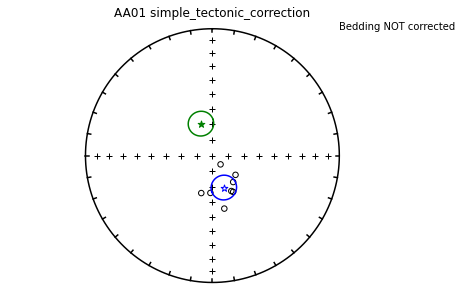

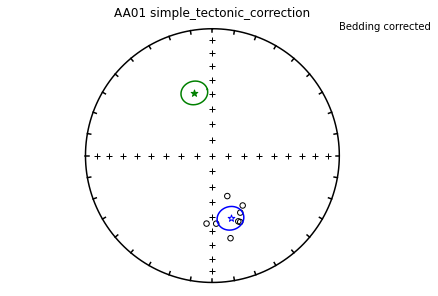

,n,Dg,Ig,r,k,alpha95,csd,n,Ds,Is,r,k,alpha95,csd,Q,coord sys
Reverse,8,160.3,-68.1,7.9,48.6,8.0,11.6,8,163.9,-47.2,7.9,48.6,8.0,11.6,2-1,simple_tectonic_correction
all to normal,8,340.3,68.1,7.9,48.6,8.0,11.6,8,343.9,47.2,7.9,48.6,8.0,11.6,2-1,simple_tectonic_correction


In [13]:
coord_sys =  "simple_tectonic_correction"

if 'di_g' in globals():
    means_g = fisher_means(di_g,1, tc = False, coord_sys = coord_sys)
    # saving plot to file
    plt.savefig(path+site_name+'_stereplot_notc.pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)
if 'di_s' in globals():
    means_s = fisher_means(di_s,2, tc = True, coord_sys = coord_sys)
    # saving plot to file
    plt.savefig(path+site_name+'_stereplot_tc.pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)

plt.show()
if 'di_g' in globals():
    if 'di_s' in globals():
        means = pd.concat([means_g,means_s], axis =1).round(1)
    else:
        means = means_g
else:
    means = means_s

means['Q'] = (str(Qmin)+'-'+str(Qmax))  #adding Quality column
means['coord sys'] = coord_sys   #adding coordinate system
aggregated_means = means
aggregated_means

### Mean directions after regional tilt corrected

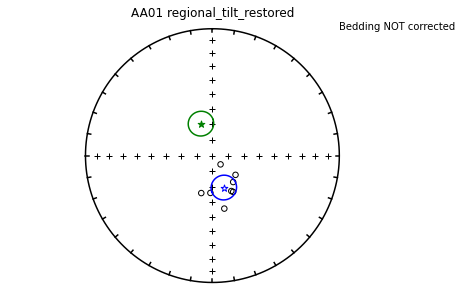

,n,Dg,Ig,r,k,alpha95,csd,Q,coord sys
Reverse,8,160.31,-68.13,7.86,48.6,8.02,11.62,2-1,regional_tilt_restored
all to normal,8,340.31,68.13,7.86,48.6,8.02,11.62,2-1,regional_tilt_restored


In [14]:
coord_sys = "regional_tilt_restored"
di_reguntilt = np.array([Selecteddata["D_reguntilt"], Selecteddata["I_reguntilt"]]).transpose()
means_g_untilt = fisher_means(di_reguntilt,1, tc = False, coord_sys = coord_sys, foldaxis_plunge = False)
means_g_untilt['Q'] = (str(Qmin)+'-'+str(Qmax))
means_g_untilt['coord sys'] = coord_sys   #adding coordinate system

# saving plot to file
plt.savefig(path+site_name+coord_sys+'_stereplot.pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)
plt.show()

means_g_untilt

### Mean directions after fold axis unplunged

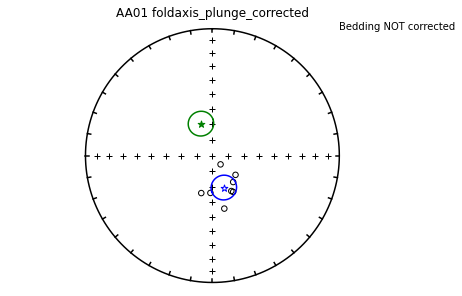

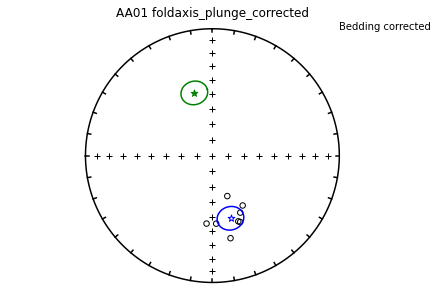

Add mean to output?: (y/n)y
Adding mean after foldaxis_plunge_corrected


,n,Dg,Ig,r,k,alpha95,csd,n,Ds,Is,r,k,alpha95,csd,Q,coord sys
Reverse,8,160.3,-68.1,7.9,48.6,8.0,11.6,8,163.9,-47.2,7.9,48.6,8.0,11.6,2-1,foldaxis_plunge_corrected
all to normal,8,340.3,68.1,7.9,48.6,8.0,11.6,8,343.9,47.2,7.9,48.6,8.0,11.6,2-1,foldaxis_plunge_corrected


In [15]:
coord_sys =  "foldaxis_plunge_corrected"
if 'D_unplunge' in Selecteddata.columns:
    di_unplunge =np.array([Selecteddata["D_unplunge"], Selecteddata["I_unplunge"]]).transpose()
if 'Ds_unplunge' in Selecteddata.columns:
    di_s_unplng =np.array([Selecteddata["Ds_unplunge"], Selecteddata["Is_unplunge"]]).transpose()

means_g_unplng = fisher_means(di_unplunge,1, tc = False, coord_sys = coord_sys)
# saving plot to file
plt.savefig(path+site_name+coord_sys+'_stereplo_notc.pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)

means_s__unplng = fisher_means(di_s_unplng,2, tc = True, coord_sys = coord_sys)
# saving plot to file
plt.savefig(path+site_name+coord_sys+'_stereplot_tc.pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)
plt.show()

means = pd.concat([means_g_unplng,means_s__unplng], axis =1).round(1)
means['Q'] = (str(Qmin)+'-'+str(Qmax))   #adding Quality column
means['coord sys'] = coord_sys   #adding coordinate system

addmeans = input('Add mean to output?: (y/n)')
if addmeans == 'y':
    aggregated_means = pd.concat([aggregated_means, means], axis = 0)
    print('Adding mean after '+ coord_sys)
else:
    pass

means

### Inclination error test

In [16]:
#test for inclination error
inc_error_test = ''
while inc_error_test != "y" and inc_error_test != "n":
    print('RUN inclination error test?')
    inc_error_test = str(input("(y/n)?:"))
    if inc_error_test == 'y':
        # shift all samples to single polarity
        mode_N,mode_R=pmag.separate_directions(di_s) #mode_1,mode_2: 2 arrays of nested dec,inc pairs
        all_to_single = mode_N
        if mode_R.any():
            to_single_mode_R_dec = mode_R.transpose()[0]+180 # all_to_single mode: all directions shifted to one polarity
            to_single_mode_R_inc = - mode_R.transpose()[1]
            to_single_mode_R = np.array([to_single_mode_R_dec,to_single_mode_R_inc]).transpose()
            if mode_N.any():
                all_to_single = np.concatenate((mode_N,to_single_mode_R))
            else:
                all_to_single = mode_R
        else:
            pass
        #run function
        ipmag.find_ei(all_to_single) # select data to analyse (mode_1, mode_2 or all_to_single)
       
    if inc_error_test == "n":
        pass

RUN inclination error test?
(y/n)?:n



### Save excel file

In [17]:
outputfile = path+site_name+"-Q"+str(Qmin)+'-'+str(Qmax)+"_means.xlsx"
export_file = ''
while export_file != "y" and export_file != "n":
    print('save and overwrite', outputfile +'?')
    export_file = str(input("(y/n)?:"))
    if export_file == 'y':
        aggregated_means.to_excel(outputfile)
        print("file saved to ", outputfile)
    if export_file == "n":
        print("file with mean directions NOT saved")

save and overwrite AA01-Q2-1_means.xlsx?
(y/n)?:y
file saved to  AA01-Q2-1_means.xlsx


In [18]:
aggregated_means

,n,Dg,Ig,r,k,alpha95,csd,n,Ds,Is,r,k,alpha95,csd,Q,coord sys
Reverse,8,160.3,-68.1,7.9,48.6,8.0,11.6,8,163.9,-47.2,7.9,48.6,8.0,11.6,2-1,simple_tectonic_correction
all to normal,8,340.3,68.1,7.9,48.6,8.0,11.6,8,343.9,47.2,7.9,48.6,8.0,11.6,2-1,simple_tectonic_correction
Reverse,8,160.3,-68.1,7.9,48.6,8.0,11.6,8,163.9,-47.2,7.9,48.6,8.0,11.6,2-1,foldaxis_plunge_corrected
all to normal,8,340.3,68.1,7.9,48.6,8.0,11.6,8,343.9,47.2,7.9,48.6,8.0,11.6,2-1,foldaxis_plunge_corrected
